# RL in Elevator Dispatch
*Course Project Final Report*

*Reinforcement Learning and Decision Making Under Uncertainty,*

*University of Neuchatel, Spring 2025*

Author: William Dan

Student Number:  24-122-749

Github URL: https://github.com/william-dan/rl-elevator



## Clone the project from Github and install the gym environment

In [1]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


In [2]:
!git clone https://github.com/william-dan/rl-elevator.git
%cd /content/rl-elevator
!pip install -e .

Cloning into 'rl-elevator'...
remote: Enumerating objects: 348, done.
remote: Counting objects: 100% (348/348), done.
remote: Compressing objects: 100% (243/243), done.
remote: Total 348 (delta 151), reused 294 (delta 100), pack-reused 0 (from 0)
Receiving objects: 100% (348/348), 8.10 MiB | 14.76 MiB/s, done.
Resolving deltas: 100% (151/151), done.
/content/rl-elevator
Obtaining file:///content/rl-elevator
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 125.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 41.9 MB/s eta 0:00:00
  Building editable

## Prepare for the training

In [3]:
# define all the libs here
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from Solver.LOOK import LOOKSolver
import random
import Elevators
import os
import csv

In [4]:
# some utils functions
def get_device(device_id):
    return torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

def make_reproducible(seed=0):
    """Sets random seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0))
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def action_flatten_to_matrix(action, num_floors, num_cars):
    return (action % (num_floors+1), action // (num_floors+1))

def action_matrix_to_flatten(action, num_floors, num_cars):
    return action[1] * (num_floors+1) + action[0]

def render_subplot(figList):
  """
  figList is a list of tuples (name, data)
  name is the name of the subplot
  data is the data to be plotted
  data: (x, [(y, label, xlabel, ylabel, title)])
  """
  WIDTH = 3

  # fig.delaxes(axes[1][2])
  # Initialize a figure and axes for the subplots
  fig, axes = plt.subplots(len(figList) // WIDTH + 1, WIDTH, figsize=(WIDTH * 6, (len(figList) // WIDTH + 1) * 6))
  axes = axes.flatten()
  for i, (name, data) in enumerate(figList):
    x, yList = data
    for y, label, xlabel, ylabel, title in yList:
      axes[i].plot(x, y, label=label)
      axes[i].set_xlabel(xlabel)
      axes[i].set_ylabel(ylabel)
      axes[i].set_title(title)
      axes[i].legend()

  plt.tight_layout()
  plt.show()

device = get_device(0)
make_reproducible(0)




In [5]:
class ActorCriticNetwork(nn.Module):
    def __init__(self, state_size, n_outputs, hidden_dim_size):
        super(ActorCriticNetwork, self).__init__()

        self.state_size = state_size
        self.n_outputs = n_outputs
        self.hidden_dim_size = hidden_dim_size

        # Shared backbone - fully connected layers for the preprocessed state
        self.shared_backbone = nn.Sequential(
            nn.Linear(state_size, self.hidden_dim_size),
            nn.ReLU(),
            nn.Linear(self.hidden_dim_size, self.hidden_dim_size),
            nn.ReLU(),
            nn.Linear(self.hidden_dim_size, self.hidden_dim_size),
            nn.ReLU()
        )

        # Policy head
        self.policy_head = nn.Sequential(
            nn.Linear(self.hidden_dim_size, self.n_outputs)
        )

        # Value head
        self.value_head = nn.Sequential(
            nn.Linear(self.hidden_dim_size, 1)
        )

    def forward(self, state):

        # Pass through the shared backbone
        shared_features = self.shared_backbone(state)

        # Policy head
        logits = self.policy_head(shared_features)
        probs = F.softmax(logits, dim=-1)
        log_probs = F.log_softmax(logits, dim=-1)

        # Value head
        value = self.value_head(shared_features)

        return probs, log_probs, value

## Policy Gradient with baseline

In [15]:
from math import isnan

# prompt: Use curriculum learning in RL

class PolicyGradientWithBaseline(object):
  def __init__(self, env, N, M):
    self.N = N
    self.M = M
    self.env = env
    # self.net = CNN().to(device)
    self.ac = ActorCriticNetwork(state_size=N*M*5, n_outputs=(N+1)*M, hidden_dim_size=256).to(device)
    self.optimizer = torch.optim.Adam(params=self.ac.parameters(), lr=2e-5)
    # self.policy = PolicyNetwork(n_inputs=N*M*5, n_outputs=(N+1)*M, hidden_dim_size=256).to(device)
    # self.value = ValueNetwork(num_states=N*M*5, hidden_dim=256).to(device)
    # self.policy_optimizer = torch.optim.Adam(params=self.policy.parameters(), lr=5e-5)
    # self.value_optimizer = torch.optim.Adam(params=self.value.parameters(), lr=1e-3)
    # placeholders for rewards for each episode
    self.rewards = []
    self.losses =  []
    self.steps = []
    # self.policy_losses = []
    # self.value_losses = []
    self.teacher_model = LOOKSolver(self.env)

  def save_model(self, ac_path="/content/drive/MyDrive/PG-ac.pth", optimizer_path="/content/drive/MyDrive/PG-optimizer.pth"):
    torch.save(self.ac.state_dict(), ac_path)
    torch.save(self.optimizer.state_dict(), optimizer_path)
    # torch.save(self.policy.state_dict(), "/content/drive/MyDrive/PG-policy.pth")
    # torch.save(self.value.state_dict(), "/content/drive/MyDrive/PG-value.pth")
    # torch.save(self.policy_optimizer.state_dict(), "/content/drive/MyDrive/PG-policy-optimizer.pth")
    # torch.save(self.value_optimizer.state_dict(), "/content/drive/MyDrive/PG-value-optimizer.pth")

  def load_model(self, ac_path="/content/drive/MyDrive/PG-ac.pth", optimizer_path="/content/drive/MyDrive/PG-optimizer.pth"):
    # self.policy.load_state_dict(torch.load("/content/drive/MyDrive/PG-policy.pth"))
    # self.value.load_state_dict(torch.load("/content/drive/MyDrive/PG-value.pth"))
    # self.policy_optimizer.load_state_dict(torch.load("/content/drive/MyDrive/PG-policy-optimizer.pth"))
    # self.value_optimizer.load_state_dict(torch.load("/content/drive/MyDrive/PG-value-optimizer.pth"))
    self.ac.load_state_dict(torch.load(ac_path))
    self.optimizer.load_state_dict(torch.load(optimizer_path))

  def train(self, num_trajectories=600, max_episode_length=400, gamma=0.99, is_curriculum=True, curriculum_start_prob=1.0, curriculum_end_prob=0.1):
    # iterating through trajectories
    for tau in tqdm(range(num_trajectories)):
      # Calculate the current teacher probability
      teacher_prob = curriculum_start_prob - (tau / (num_trajectories - 1)) * (curriculum_start_prob - curriculum_end_prob)
      teacher_prob = max(curriculum_end_prob, teacher_prob) # Ensure it doesn't go below the end probability

      # resetting the environment
      state, info = self.env.reset()
      self.teacher_model.reset(info)

      # setting done to False for while loop
      done = False
      # storing trajectory and logπ(a_t|s_t, θ)
      transition_buffer = []
      log_probs = []
      state_values =[]

      t = 0
      clk = 0.0
      while done == False and info["time"] < max_episode_length:
          # features = self.net(torch.tensor(state).to(device).permute(2, 0, 1).unsqueeze(0))
          # retrieving π and logπ
          action_probs, action_log_probs, state_value = self.ac(torch.tensor(state).to(device).flatten())
          # action_probs, action_log_probs = self.policy(preprocess_state(torch.tensor(state).to(device).flatten()))
          if np.isnan(action_log_probs.detach().cpu().sum()):
            print("action_log_probs.sum() is nan")
            raise ValueError("action_log_probs.sum() is nan")
          # retrieving value of the state we're currently in
          # state_value = self.value(preprocess_state(torch.tensor(state).to(device).flatten()))

          if is_curriculum and random.random() < teacher_prob:
            # Use the teacher's action
            action = self.teacher_model.get_next_action((state, info))
          else:
            # Sample action from the learned policy
            action_probs_np = action_probs.flatten().detach().cpu().numpy()
            action = np.random.choice(np.arange(len(action_probs_np)), p=action_probs_np)
            action = action_flatten_to_matrix(action, self.N, self.M)

          # keeping track of previous state
          prev_state = state
          # environment step

          state, reward, done, truncation, info = self.env.step(action)
          # storing rewards, logπ and state values
          transition_buffer.append(reward)
          log_probs.append(action_log_probs[action_matrix_to_flatten(action, self.N, self.M)])
          state_values.append(state_value)
          t += 1
      # logging the episode length as a cumulative reward
      self.rewards.append(sum(transition_buffer))
      returns = []
      for t_prime in range(t):
          # computing discounted rewards in future for every timestep
          G = 0
          for i, tick in enumerate(transition_buffer[t_prime:]):
              G += (gamma ** i) * tick
          returns.append(G)

      # turning the returns vector into a tensor
      returns = torch.tensor(returns).to(device)
      # creating the advantage term δ
      deltas = returns - torch.tensor(state_values).to(device)

      # computing the gradients for each timestep
      policy_gradients = []
      value_gradients = []

      # policy_deltas = deltas
      # value_deltas = deltas.clone()
      # using Sutton & Barto losses for value function and policy
      for t, (log_prob, d) in enumerate(zip(log_probs, deltas)):
          policy_gradients.append(- log_prob * d)
      for d, V in zip(deltas, state_values):
          value_gradients.append( - d * V)
      self.steps.append(t)

      self.optimizer.zero_grad()
      loss = torch.stack(policy_gradients).sum() + torch.stack(value_gradients).sum()
      self.losses.append(loss.item())
      loss.backward()
      torch.nn.utils.clip_grad_norm_(self.ac.parameters(), 0.5)
      self.optimizer.step()
      # # updating the policy network
      # self.policy_optimizer.zero_grad()
      # # summing all gradients for one batch update instead of update at each timestep
      # policy_loss = torch.stack(policy_gradients).sum()
      # self.policy_losses.append(policy_loss.item())
      # policy_loss.backward()
      # torch.nn.utils.clip_grad_norm_(self.policy.parameters(), 0.5)
      # self.policy_optimizer.step()
      # # updating the value network
      # self.value_optimizer.zero_grad()
      # value_loss = torch.stack(value_gradients).sum()
      # self.value_losses.append(value_loss.item())
      # value_loss.backward()
      # torch.nn.utils.clip_grad_norm_(self.value.parameters(), 0.5)

      # self.value_optimizer.step()

  def plot_rewards_and_losses(self, interval):
    # plot the results of the training
    plt.figure(figsize=(12,9))
    plt.plot(running_mean(self.rewards,interval))
    plt.grid()
    plt.title("REINFORCE cumulative rewards")
    plt.figure(figsize=(12,9))
    plt.plot(running_mean(self.losses,interval))
    plt.grid()
    plt.title("REINFORCE losses")
    # plt.figure(figsize=(12,9))
    # plt.plot(running_mean(self.policy_losses,interval))
    # plt.grid()
    # plt.title("REINFORCE policy losses")
    # plt.figure(figsize=(12,9))
    # plt.plot(running_mean(self.value_losses,interval))
    # plt.grid()
    # plt.title("REINFORCE value losses")

  def export_rewards_to_csv(self):
    # Export rewards to CSV
    with open(f'/content/drive/MyDrive/PG_Baseline_rewards_{self.N}_{self.M}.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Episode', 'Reward'])
        for episode, reward in enumerate(self.rewards):
            writer.writerow([episode, reward])

  def export_losses_to_csv(self):
    # Export losses to CSV
    with open(f'/content/drive/MyDrive/PG_Baseline_losses_{self.N}_{self.M}.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Episode', 'Loss'])
        for episode, loss in enumerate(self.losses):
            writer.writerow([episode, loss])


  def export_steps_to_csv(self):
    # Export losses to CSV
    with open(f'/content/drive/MyDrive/PG_Baseline_steps_{self.N}_{self.M}.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Episode', 'Steps'])
        for episode, steps in enumerate(self.steps):
            writer.writerow([episode, steps])



  def get_next_action(self, obs):
    action_probs, _, _ = self.ac(torch.tensor(obs).to(device).flatten())
    # action_probs, _ = self.policy(torch.tensor(obs).to(device).flatten())
    action_probs_np = action_probs.flatten().detach().cpu().numpy()
    action = np.random.choice(np.arange(len(action_probs_np)), p=action_probs_np)
    return action


In [17]:
class Solver():
    def __init__(self, env: gym.Env, model, N, M):
        self.env = env
        self.model = model
        self.N = N
        self.M = M

    def reset(self):
        pass

    def get_next_action(self, obs):
        return self.model.get_next_action(obs)


    def run_episode(self, max_steps=100, render=False):
        obs, info = self.env.reset()
        self.reset()
        total_reward = 0
        # for _ in range(max_steps):
        while info["time"] < max_steps:
            action = self.get_next_action(obs)
            obs, reward, done, truncated, info = self.env.step(action_flatten_to_matrix(action, self.N, self.M))
            if render:
              self.env.render()
            total_reward += reward
            if done or truncated:
                break
        print(f"info[\"done\"]: {info['done']}")
        # print(f"info[\"waiting\"]: {info['waiting']}")
        # print(f"info[\"time\"]: {info['time']}")

        return total_reward

    def plot(self, rewards):
        plt.figure(figsize=(10, 5))
        plt.plot(rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('PGWithBaselineSolver Performance')
        plt.savefig("PGWithBaseline_performance.png")
        plt.show()



    def benchmark(self, num_episodes=100, render=False):
        rewards = []
        for _ in range(num_episodes):
            total_reward = self.run_episode(render=render)
            rewards.append(total_reward)
        return rewards

In [18]:
def render_test(model_class, N, M, seed=0):
  env = gym.make("Elevators/Elevators-v0",
                   num_floors=N,
                   num_cars=M,
                   avg_passengers_spawning_time=5,
                   total_passengers=1000000,
                   seed=seed)
  model = model_class(env, N, M)
  model.load_model(ac_path=f"/content/drive/MyDrive/{model_class.__name__}-ac-bad-{N}-{M}.pth", optimizer_path=f"/content/drive/MyDrive/{model_class.__name__}-optimizer-bad-{N}-{M}.pth")
  solver = Solver(env, model, N, M)
  rewards = solver.benchmark(num_episodes=1, render=True)
  print(rewards)

In [19]:
def rewards_test(model_class, N, M):
  env = gym.make("Elevators/Elevators-v0",
                   num_floors=N,
                   num_cars=M,
                   avg_passengers_spawning_time=5,
                   total_passengers=1000000,
                   seed=0)
  model = model_class(env, N, M)
  model.load_model(ac_path=f"/content/drive/MyDrive/{model_class.__name__}-ac-{N}-{M}.pth", optimizer_path=f"/content/drive/MyDrive/{model_class.__name__}-optimizer-{N}-{M}.pth")
  solver = Solver(env, model, N, M)
  rewards = solver.benchmark(num_episodes=1000)
  with open(f'/content/drive/MyDrive/{model_class.__name__}_test_rewards_{N}_{M}.csv', 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)
      writer.writerow(['Episode', 'Reward'])
      for episode, reward in enumerate(rewards):
          writer.writerow([episode, reward])


In [21]:
def benchmark(model_class, N, M, epochs=2000):
  env = gym.make("Elevators/Elevators-v0",
                   num_floors=N,
                   num_cars=M,
                   avg_passengers_spawning_time=5,
                   total_passengers=1000000,
                   seed=0)
  # make_reproducible(30)
  model = model_class(env, N, M)

  # if os.path.exists(f"/content/drive/MyDrive/{model_class.__name__}-ac-{N}-{M}.pth"):
  #   model.load_model(ac_path=f"/content/drive/MyDrive/{model_class.__name__}-ac-{N}-{M}.pth", optimizer_path=f"/content/drive/MyDrive/{model_class.__name__}-optimizer-{N}-{M}.pth")


  model.train(num_trajectories=epochs, max_episode_length=100, is_curriculum=False)
  model.save_model(ac_path=f"/content/drive/MyDrive/{model_class.__name__}-ac-bad-{N}-{M}.pth", optimizer_path=f"/content/drive/MyDrive/{model_class.__name__}-optimizer-bad-{N}-{M}.pth")
  model.plot_rewards_and_losses(100)
  model.export_losses_to_csv()
  model.export_rewards_to_csv()
  model.export_steps_to_csv()

  env = gym.make("Elevators/Elevators-v0",
                   num_floors=N,
                   num_cars=M,
                   avg_passengers_spawning_time=5,
                   total_passengers=1000000,
                   seed=0)
  # Initialize the LOOK solver
  look_solver = LOOKSolver(env)

  # Run a simulation using the LOOK solver
  num_steps = 100
  total_reward_look = 0
  state, info = env.reset()
  look_solver.reset(info)

  print("Running LOOK benchmark...")
  while info["time"] < num_steps:
      action = look_solver.get_next_action((state, info))
      state, reward, done, truncation, info = env.step(action)
      # look_solver.env.render()
      total_reward_look += reward
      if done or truncation:
          break

  print(info["done"])
  print(f"\nTotal reward for LOOK benchmark over {num_steps} steps: {total_reward_look}")

  avg_reward = -1e9
  t = 0
  while avg_reward < total_reward_look and t < 100:
    t += 1
    env = gym.make("Elevators/Elevators-v0",
                    num_floors=N,
                    num_cars=M,
                    avg_passengers_spawning_time=5,
                    total_passengers=1000000,
                    #  capacity=4,
                    seed=0)
    model = model_class(env, N, M)
    model.load_model(ac_path=f"/content/drive/MyDrive/{model_class.__name__}-ac-bad-{N}-{M}.pth", optimizer_path=f"/content/drive/MyDrive/{model_class.__name__}-optimizer-bad-{N}-{M}.pth")
    solver = Solver(env, model, N, M)
    rewards = solver.benchmark(num_episodes=1)
    avg_reward = sum(rewards) / len(rewards)

  print(f"Average reward: {avg_reward}")
  solver.plot(rewards)

In [ ]:
benchmark(PolicyGradientWithBaseline,3,1,100)

In [ ]:
benchmark(PolicyGradientWithBaseline,6,1,100)

In [25]:
rewards_test(PolicyGradientWithBaseline,3,1)

info["done"]: 45
info["done"]: 52
info["done"]: 17
info["done"]: 31
info["done"]: 52
info["done"]: 69
info["done"]: 51
info["done"]: 44
info["done"]: 64
info["done"]: 34
info["done"]: 42
info["done"]: 66
info["done"]: 70
info["done"]: 14
info["done"]: 33
info["done"]: 74
info["done"]: 72
info["done"]: 6
info["done"]: 31
info["done"]: 33
info["done"]: 23
info["done"]: 24
info["done"]: 38
info["done"]: 122
info["done"]: 52
info["done"]: 34
info["done"]: 46
info["done"]: 16
info["done"]: 70
info["done"]: 66
info["done"]: 67
info["done"]: 14
info["done"]: 18
info["done"]: 42
info["done"]: 100
info["done"]: 32
info["done"]: 20
info["done"]: 64
info["done"]: 82
info["done"]: 53
info["done"]: 41
info["done"]: 20
info["done"]: 25
info["done"]: 13
info["done"]: 11
info["done"]: 41
info["done"]: 45
info["done"]: 34
info["done"]: 61
info["done"]: 32
info["done"]: 9
info["done"]: 64
info["done"]: 31
info["done"]: 31
info["done"]: 57
info["done"]: 26
info["done"]: 43
info["done"]: 49
info["done"]: 

In [26]:
rewards_test(PolicyGradientWithBaseline,6,1)

info["done"]: 0
info["done"]: 11
info["done"]: 2
info["done"]: 10
info["done"]: 8
info["done"]: 16
info["done"]: 5
info["done"]: 24
info["done"]: 15
info["done"]: 3
info["done"]: 16
info["done"]: 3
info["done"]: 2
info["done"]: 12
info["done"]: 14
info["done"]: 12
info["done"]: 2
info["done"]: 15
info["done"]: 13
info["done"]: 15
info["done"]: 13
info["done"]: 15
info["done"]: 28
info["done"]: 12
info["done"]: 8
info["done"]: 16
info["done"]: 5
info["done"]: 27
info["done"]: 20
info["done"]: 21
info["done"]: 14
info["done"]: 14
info["done"]: 18
info["done"]: 22
info["done"]: 13
info["done"]: 11
info["done"]: 1
info["done"]: 15
info["done"]: 3
info["done"]: 21
info["done"]: 20
info["done"]: 15
info["done"]: 20
info["done"]: 0
info["done"]: 35
info["done"]: 2
info["done"]: 12
info["done"]: 12
info["done"]: 9
info["done"]: 15
info["done"]: 29
info["done"]: 18
info["done"]: 2
info["done"]: 41
info["done"]: 11
info["done"]: 15
info["done"]: 18
info["done"]: 15
info["done"]: 14
info["done"]:

In [ ]:
render_test(PolicyGradientWithBaseline,3,1,0)

In [ ]:
render_test(PolicyGradientWithBaseline,6,1,0)

## 1 step Actor Critic

In [32]:
class ActorCriticOneStep(object):
  def __init__(self, env, N, M):
    self.N = N
    self.M = M
    self.ac = ActorCriticNetwork(state_size=N*M*5, n_outputs=(N+1)*M, hidden_dim_size=256).to(device)
    self.optimizer = torch.optim.Adam(params=self.ac.parameters(), lr=2e-5)
    self.env = env
    self.rewards = []
    self.losses = []
    self.steps = []

  def save_model(self, ac_path, optimizer_path):
    torch.save(self.ac.state_dict(), ac_path)
    torch.save(self.optimizer.state_dict(), optimizer_path)

  def load_model(self, ac_path, optimizer_path):
    self.ac.load_state_dict(torch.load(ac_path))
    self.optimizer.load_state_dict(torch.load(optimizer_path))

  def train(self, num_trajectories=500, max_episode_length=100, gamma=0.99, is_curriculum=False):
    # iterating through trajectories
    for tau in tqdm(range(num_trajectories)):
        # resetting the environment
        state, info = self.env.reset(seed=123)
        # setting done to False for while loop
        done = False

        t = 0
        rewardSum = 0.0
        losses_per_episode = []
        while done == False and info["time"] < max_episode_length:
            # retrieving π and logπ
            action_probs, action_log_probs, state_value = self.ac(torch.tensor(state).to(device).flatten())
            if np.isnan(action_log_probs.detach().cpu().sum()):
              print("action_log_probs.sum() is nan")
              raise ValueError("action_log_probs.sum() is nan")

            # sampling the action according to the distribution given by π
            action_probs_np = action_probs.flatten().detach().cpu().numpy()
            action = np.random.choice(np.arange(len(action_probs_np)), p=action_probs_np)
            # print(action, action_formatted)
            # keeping track of previous state
            prev_state = state
            # environment step
            state, reward, done, truncation, info = self.env.step(action_flatten_to_matrix(action, self.N, self.M))
            # getting the value of next state - no value if the state is terminal
            if done == False:
                _, _, next_state_value = self.ac(torch.tensor(state).to(device).flatten())
            else:
                next_state_value = torch.tensor(0.).to(device)

            # delta computation
            reward = torch.tensor(reward).to(device)
            rewardSum += reward.item()
            # detaching the next state gradients for the value function update
            delta = reward + gamma * next_state_value.detach() - state_value

            self.optimizer.zero_grad()
            loss = delta ** 2 - delta * action_log_probs[action]
            # loss = delta
            losses_per_episode.append(loss.item())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.ac.parameters(), 0.5)
            self.optimizer.step()

            t += 1
        self.losses.append(torch.Tensor(losses_per_episode).mean().item())
        self.steps.append(t)
        self.rewards.append(rewardSum)

  def plot_rewards_and_losses(self, interval):
    # plot the results of the training
    plt.figure(figsize=(12,9))
    plt.plot(running_mean(self.rewards,interval))
    plt.grid()
    plt.title("REINFORCE cumulative rewards")
    plt.figure(figsize=(12,9))
    plt.plot(running_mean(self.losses,interval))
    plt.grid()
    plt.title("REINFORCE losses")

  def export_rewards_to_csv(self):
    # Export rewards to CSV
    with open(f'/content/drive/MyDrive/AC_rewards_{self.N}_{self.M}.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Episode', 'Reward'])
        for episode, reward in enumerate(self.rewards):
            writer.writerow([episode, reward])

  def export_losses_to_csv(self):
    # Export losses to CSV
    with open(f'/content/drive/MyDrive/AC_losses_{self.N}_{self.M}.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Episode', 'Loss'])
        for episode, loss in enumerate(self.losses):
            writer.writerow([episode, loss])

  def export_steps_to_csv(self):
    # Export losses to CSV
    with open(f'/content/drive/MyDrive/AC_steps_{self.N}_{self.M}.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['Episode', 'Steps'])
        for episode, steps in enumerate(self.steps):
            writer.writerow([episode, steps])



  def get_next_action(self, obs):
    action_probs, action_log_probs, state_value = self.ac(torch.tensor(obs).to(device).flatten())
    action_probs_np = action_probs.flatten().detach().cpu().numpy()
    action = np.random.choice(np.arange(len(action_probs_np)), p=action_probs_np)
    return action



In [ ]:
benchmark(ActorCriticOneStep, 3, 1, 100)

In [ ]:
benchmark(ActorCriticOneStep, 6, 1, 100)

In [ ]:
rewards_test(ActorCriticOneStep, 3, 1)

In [ ]:
rewards_test(ActorCriticOneStep, 6, 1)

In [ ]:
render_test(ActorCriticOneStep, 3, 1,0)

In [ ]:
render_test(ActorCriticOneStep, 6, 1, 0)

In [ ]:
!pip install stable-baselines3[extra]
from stable_baselines3 import PPO as SB3_PPO
from stable_baselines3.common.env_util import make_vec_env
import wandb
from wandb.integration.sb3 import WandbCallback
from stable_baselines3.common.callbacks import BaseCallback
# from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.logger import configure


In [97]:

class SB3PPOSolver():
    def __init__(self, env: gym.Env, model):
        self.env = env
        self.model = model

    def reset(self):
        pass

    def get_next_action(self, obs):
        # SB3 model expects a batch of observations, even for a single environment step during evaluation
        action, _states = self.model.predict(obs, deterministic=False)
        # print(action)
        # SB3 predicts flattened actions for MultiDiscrete. We need to convert it back
        # return action_flatten_to_matrix(action.item(), N, M)
        return action

    def run_episode(self, max_steps=100, render=False):
        obs, info = self.env.reset()
        self.reset()
        total_reward = 0
        while info["time"] < max_steps:
            action = self.get_next_action(obs)
            obs, reward, done, truncated, info = self.env.step(action) # SB3 model directly gives the action in the environment's action space
            total_reward += reward
            if render:
              self.env.render()
            if done or truncated:
                break
        print(f"info[\"done\"]: {info['done']}")
        return total_reward

    def plot(self, rewards):
        plt.figure(figsize=(10, 5))
        plt.plot(rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('SB3 PPOSolver Performance')
        plt.savefig("SB3_PPO_performance.png")
        plt.show()


    def benchmark(self, num_episodes=100, render=False):
        rewards = []
        for _ in range(num_episodes):
            total_reward = self.run_episode(max_steps=100, render=render)
            rewards.append(total_reward)
        return rewards

In [33]:
class EpisodeRewardCallback(BaseCallback):
    """Collect per‑episode rewards and push them wherever you like."""
    def __init__(self, verbose: int = 0, n_steps = 2048, N=3, M=1):
        super().__init__(verbose)
        self.episode_rewards = []
        self.n_steps = n_steps
        self.current_step = 0
        self.N = N
        self.M = M

    def _on_step(self) -> bool:
        # print(f"on_step")
        # `infos` is a list (one per env if vectorized)
        self.current_step += 1
        if self.current_step % self.n_steps == 0:

          for info in self.locals["infos"]:

              if "reward" in info:               # signals an episode just ended
                  r = info["reward"]        # total reward
                  self.episode_rewards.append(r)   # stash locally

                  # 👉 Log to SB3's logger so it shows up in TensorBoard
                  self.logger.record("episode_reward", r)

                  # 👉 Or: write to disk / DB / live plot here
                  if self.verbose:
                      print(f"Episode done — reward = {r}")
        return True

    def _on_training_end(self) -> None:
        """
        save the rewards to csv file
        """
        # Export rewards to CSV
        with open(f'/content/drive/MyDrive/PPO_rewards_{self.N}_{self.M}.csv', 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['Episode', 'Reward'])
            for episode, reward in enumerate(self.episode_rewards):
                writer.writerow([episode, reward])


In [128]:
def render_test_ppo(model_class, N, M, seed=0):
  threshold = 1200
  max_times = 100
  for i in range(max_times):
    env = gym.make("Elevators/Elevators-v0",
                    num_floors=N,
                    num_cars=M,
                    avg_passengers_spawning_time=5,
                    total_passengers=1000000,
                    seed=seed)
    model = model_class("MlpPolicy", env, verbose=1, device=device)
    model.load(f"/content/drive/MyDrive/{model_class.__name__}-ac-{N}-{M}.pth")
    sb3_ppo_solver = SB3PPOSolver(env, model)


    rewards = sb3_ppo_solver.benchmark(num_episodes=1, render=True)
    assert(len(rewards) == 1)
    if rewards[0] >= threshold:
      break
  print(rewards)



In [34]:
def rewards_test_ppo(model_class, N, M):
  env = gym.make("Elevators/Elevators-v0",
                   num_floors=N,
                   num_cars=M,
                   avg_passengers_spawning_time=5,
                   total_passengers=1000000,
                   seed=0)
  model = model_class("MlpPolicy", env, verbose=1, device=device)
  model.load(f"/content/drive/MyDrive/{model_class.__name__}-ac-{N}-{M}.pth")
  sb3_ppo_solver = SB3PPOSolver(env, model)
  rewards = sb3_ppo_solver.benchmark(num_episodes=1000)
  with open(f'/content/drive/MyDrive/{model_class.__name__}_test_rewards_{N}_{M}.csv', 'w', newline='') as csvfile:
      writer = csv.writer(csvfile)
      writer.writerow(['Episode', 'Reward'])
      for episode, reward in enumerate(rewards):
          writer.writerow([episode, reward])


In [35]:


def benchmark_ppo(model_class, N, M):
  n_steps = 100
  env = gym.make("Elevators/Elevators-v0",
                   num_floors=N,
                   num_cars=M,
                   avg_passengers_spawning_time=5,
                   total_passengers=1000000,
                   seed=0)


  new_logger = configure(f"/content/drive/MyDrive/ppo-{N}-{M}-log", ["stdout", "csv", "tensorboard"])

  model = model_class("MlpPolicy", env, verbose=1, device=device, n_steps = n_steps,
                      tensorboard_log=f"/content/drive/MyDrive/ppo-tensorboard-{N}-{M}/")

  # if os.path.exists(f"/content/drive/MyDrive/{model_class.__name__}-ac-{N}-{M}.pth"):
  #   model.load(f"/content/drive/MyDrive/{model_class.__name__}-ac-{N}-{M}.pth")


  model.set_logger(new_logger)
  # # Adjust the total_timesteps as needed
  model.learn(
      total_timesteps=2e5,
      callback=EpisodeRewardCallback(verbose=1, n_steps=n_steps, N=N, M=M)
  )

  # Save the trained model
  model.save(f"/content/drive/MyDrive/{model_class.__name__}-ac-{N}-{M}.pth")

  # solver = SB3PPOSolver(vec_env, model)
  # rewards = solver.benchmark(num_episodes=100)



  env = gym.make("Elevators/Elevators-v0",
                   num_floors=N,
                   num_cars=M,
                   avg_passengers_spawning_time=5,
                   total_passengers=1000000,
                   seed=0)
  # Initialize the LOOK solver
  look_solver = LOOKSolver(env)

  # Run a simulation using the LOOK solver
  num_steps = 100
  total_reward_look = 0
  state, info = env.reset()
  look_solver.reset(info)

  print("Running LOOK benchmark...")
  while info["time"] < num_steps:
      action = look_solver.get_next_action((state, info))
      state, reward, done, truncation, info = env.step(action)
      # look_solver.env.render()
      total_reward_look += reward
      if done or truncation:
          break

  print(info["done"])
  print(f"\nTotal reward for LOOK benchmark over {num_steps} steps: {total_reward_look}")

  avg_reward = 0
  t = 0
  while avg_reward < total_reward_look and t < 100:
    t += 1
    env = gym.make("Elevators/Elevators-v0",
                    num_floors=N,
                    num_cars=M,
                    avg_passengers_spawning_time=5,
                    total_passengers=1000000,
                    #  capacity=4,
                    seed=0)
    assert os.path.exists(f"/content/drive/MyDrive/{model_class.__name__}-ac-{N}-{M}.pth")
    model = model_class.load(f"/content/drive/MyDrive/{model_class.__name__}-ac-{N}-{M}.pth", optimizer_path=f"/content/drive/MyDrive/{model_class.__name__}-optimizer-{N}-{M}.pth")
    sb3_ppo_solver = SB3PPOSolver(env, model)
    sb3_ppo_rewards = sb3_ppo_solver.benchmark(num_episodes=1)
    avg_reward = sum(sb3_ppo_rewards) / len(sb3_ppo_rewards)

  print(f"Average reward: {avg_reward}")
  sb3_ppo_solver.plot(sb3_ppo_rewards)

Logging to /content/drive/MyDrive/ppo-3-1-log
Using cuda:0 device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 100`, after every 1 untruncated mini-batches, there will be a truncated mini-batch of size 36
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=100 and n_envs=1)
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


流式输出内容被截断，只能显示最后 5000 行内容。
|    time_elapsed         | 616           |
|    total_timesteps      | 175100        |
| train/                  |               |
|    approx_kl            | 5.0574643e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.383        |
|    explained_variance   | 0             |
|    learning_rate        | 0.0003        |
|    loss                 | 5.38e+04      |
|    n_updates            | 17500         |
|    policy_gradient_loss | -0.000862     |
|    value_loss           | 1.03e+05      |
-------------------------------------------
Episode done — reward = 4954341.0
-------------------------------------------
| episode_reward          | 4.95e+06      |
| time/                   |               |
|    fps                  | 283           |
|    iterations           | 1752          |
|    time_elapsed         | 617           |
|    total_timesteps      | 175200        |
| train/       

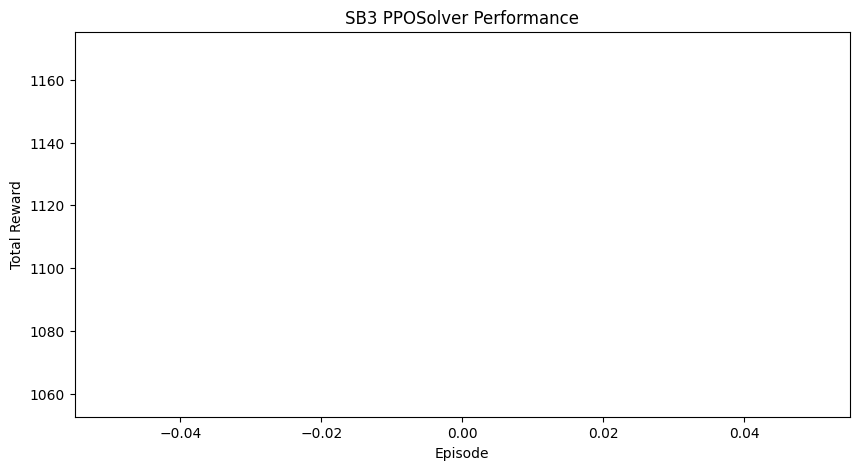

In [19]:
benchmark_ppo(SB3_PPO, 3, 1)

流式输出内容被截断，只能显示最后 5000 行内容。
|    time_elapsed         | 673         |
|    total_timesteps      | 175100      |
| train/                  |             |
|    approx_kl            | 0.004702367 |
|    clip_fraction        | 0.0053      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.1        |
|    explained_variance   | 1.19e-07    |
|    learning_rate        | 0.0003      |
|    loss                 | 1.23e+05    |
|    n_updates            | 17500       |
|    policy_gradient_loss | -0.00983    |
|    value_loss           | 1.9e+05     |
-----------------------------------------
Episode done — reward = 6458988.0
------------------------------------------
| episode_reward          | 6.46e+06     |
| time/                   |              |
|    fps                  | 259          |
|    iterations           | 1752         |
|    time_elapsed         | 674          |
|    total_timesteps      | 175200       |
| train/                  |              |
|    ap

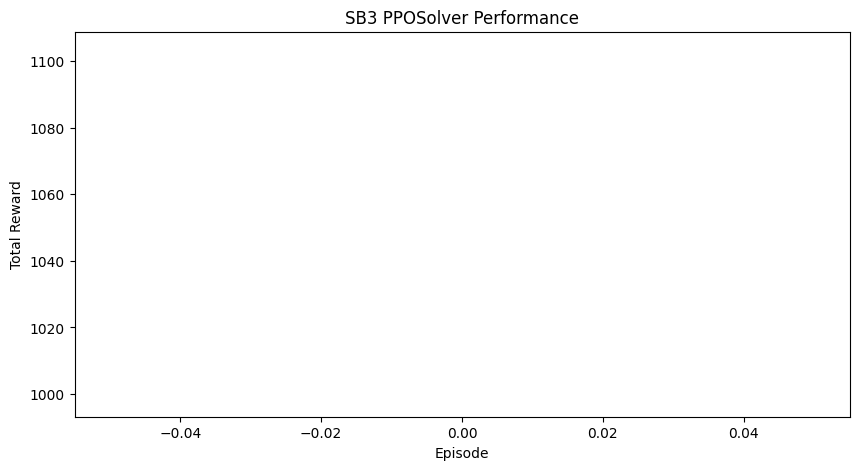

In [20]:
benchmark_ppo(SB3_PPO, 6, 1)


In [36]:
rewards_test_ppo(SB3_PPO, 3, 1)

Using cuda:0 device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


info["done"]: 44
info["done"]: 62
info["done"]: 26
info["done"]: 30
info["done"]: 77
info["done"]: 62
info["done"]: 46
info["done"]: 68
info["done"]: 74
info["done"]: 57
info["done"]: 34
info["done"]: 34
info["done"]: 55
info["done"]: 37
info["done"]: 40
info["done"]: 70
info["done"]: 79
info["done"]: 3
info["done"]: 32
info["done"]: 50
info["done"]: 27
info["done"]: 49
info["done"]: 10
info["done"]: 133
info["done"]: 103
info["done"]: 46
info["done"]: 37
info["done"]: 49
info["done"]: 118
info["done"]: 67
info["done"]: 83
info["done"]: 25
info["done"]: 25
info["done"]: 51
info["done"]: 47
info["done"]: 51
info["done"]: 51
info["done"]: 57
info["done"]: 64
info["done"]: 73
info["done"]: 42
info["done"]: 70
info["done"]: 43
info["done"]: 49
info["done"]: 73
info["done"]: 47
info["done"]: 78
info["done"]: 57
info["done"]: 41
info["done"]: 31
info["done"]: 65
info["done"]: 51
info["done"]: 17
info["done"]: 26
info["done"]: 39
info["done"]: 45
info["done"]: 25
info["done"]: 44
info["done"]

In [37]:
rewards_test_ppo(SB3_PPO, 6, 1)

Using cuda:0 device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
info["done"]: 6
info["done"]: 7
info["done"]: 0
info["done"]: 12
info["done"]: 9
info["done"]: 56
info["done"]: 10
info["done"]: 18
info["done"]: 25
info["done"]: 6
info["done"]: 10
info["done"]: 17
info["done"]: 23
info["done"]: 28
info["done"]: 8
info["done"]: 31
info["done"]: 3
info["done"]: 11
info["done"]: 31
info["done"]: 11
info["done"]: 15
info["done"]: 7
info["done"]: 52
info["done"]: 18
info["done"]: 13
info["done"]: 8
info["done"]: 20
info["done"]: 23
info["done"]: 37
info["done"]: 7
info["done"]: 13
info["done"]: 4
info["done"]: 6
info["done"]: 23
info["done"]: 21
info["done"]: 19
info["done"]: 8
info["done"]: 1
info["done"]: 17
info["done"]: 31
info["done"]: 10
info["done"]: 6
info["done"]: 23
info["done"]: 17
info["done"]: 24
info["done"]: 18
info["done"]: 0
info["done"]: 0
info["done"]: 16
info["done"]: 27
info["done"]: 12
info["done"]: 42
info["done"]: 19
info["done"]: 14
in

In [129]:
render_test_ppo(SB3_PPO, 3, 1, 0)

流式输出内容被截断，只能显示最后 5000 行内容。
 Car0 floor=2.00 dir=+1 load=0 it=None
 Hall‑calls: [0, 2]
----------------------------------------
t=44.7s | waiting=32
event: CLOSE
 Car0 floor=2.00 dir=+1 load=0 it=0
 Hall‑calls: [0, 2]
----------------------------------------
t=47.0s | waiting=32
event: OPEN
 Car0 floor=1.00 dir=-1 load=0 it=None
 Hall‑calls: [0, 2]
----------------------------------------
t=49.0s | waiting=32
event: CLOSE
 Car0 floor=1.00 dir=-1 load=0 it=2
 Hall‑calls: [0, 2]
----------------------------------------
t=51.3s | waiting=32
event: OPEN
 Car0 floor=2.00 dir=+1 load=0 it=None
 Hall‑calls: [0, 2]
----------------------------------------
t=53.1s | waiting=35
event: SPAWN
 Car0 floor=2.00 dir=+1 load=0 it=1
 Hall‑calls: [0, 2]
----------------------------------------
t=53.3s | waiting=35
event: CLOSE
 Car0 floor=2.00 dir=+1 load=0 it=0
 Hall‑calls: [0, 2]
----------------------------------------
t=54.5s | waiting=39
event: SPAWN
 Car0 floor=1.51 dir=-1 load=0 it=0
 Hall‑calls: 

In [127]:
render_test_ppo(SB3_PPO, 6, 1, 0)

流式输出内容被截断，只能显示最后 5000 行内容。
event: CLOSE
 Car0 floor=2.00 dir=+1 load=1 it=1
 Hall‑calls: [0, 1, 5]
----------------------------------------
t=53.1s | waiting=41
event: SPAWN
 Car0 floor=4.74 dir=+1 load=1 it=5
 Hall‑calls: [0, 1, 5]
----------------------------------------
t=53.8s | waiting=41
event: OPEN
 Car0 floor=5.00 dir=+1 load=0 it=None
 Hall‑calls: [0, 1, 5]
----------------------------------------
t=54.5s | waiting=45
event: SPAWN
 Car0 floor=5.00 dir=+1 load=0 it=1
 Hall‑calls: [0, 1, 5]
----------------------------------------
t=55.8s | waiting=45
event: CLOSE
 Car0 floor=5.00 dir=+1 load=0 it=2
 Hall‑calls: [0, 1, 5]
----------------------------------------
t=65.9s | waiting=48
event: SPAWN
 Car0 floor=0.67 dir=-1 load=0 it=0
 Hall‑calls: [0, 1, 4, 5]
----------------------------------------
t=67.3s | waiting=50
event: SPAWN
 Car0 floor=1.27 dir=+1 load=0 it=5
 Hall‑calls: [0, 1, 4, 5]
----------------------------------------
t=69.9s | waiting=51
event: SPAWN
 Car0 floor=0.

### Vanilla Policy-Gradient **with a baseline**

* **Signal used:** $g_t = \nabla_\theta\log\pi_\theta(a_t|s_t)\,[R_t - b]$
  \*$R_t$ is the **full Monte-Carlo return** from $t$ to the end; $b$ is a baseline (often a moving average or a learned **state-value $V_\phi(s_t)$**).
* **Variance control:** The baseline subtracts a constant (or $V_\phi$) to reduce variance, but the target is **still the complete return**, so the method remains Monte-Carlo.
* **When it breaks:** Long horizons ⇒ high variance and slow learning; still no explicit constraint on step size.

---

### **A2C – Advantage Actor-Critic (synchronous)**

* **Signal used:** $g_t = \nabla_\theta\log\pi_\theta(a_t|s_t)\,[\,R_t^{(\lambda)} - V_\phi(s_t)\,]$
  where $R_t^{(\lambda)}$ is an **n-step / GAE bootstrapped target**.
* **What’s new vs PG + baseline:**

  1. **Bootstrapping**: mixes immediate rewards with the critic’s estimate instead of waiting for the episode to finish ⇒ much lower variance & quicker feedback.
  2. **Multiple workers, one update:** “*A2C*” is simply A3C run **synchronously**; workers collect batches, then the central learner averages the gradients—hardware-friendly and stable.
* **Limitation:** Still a pure gradient step; if the learning rate is too high the policy can move far and collapse.

---

### **PPO – Proximal Policy Optimisation**

* **Signal used:** same advantage estimate as A2C, but the loss is

  $$
  L(\theta)=\mathbb{E}\big[\;
  \min\big(r_t(\theta)A_t,\;\text{clip}(r_t(\theta),1\!\pm\!\epsilon)\,A_t\big)\big]
  $$

  with $r_t=\pi_\theta/\pi_{\theta_{\text{old}}}$.
* **What’s new vs A2C:**

  1. **Trust-region by clipping (or KL penalty):** prevents $r_t$ from straying too far from 1, so each update is **safely bounded**.
  2. **Large-batch optimisation:** can reuse the same trajectories for multiple epochs, making PPO markedly **more sample-efficient**.
* **Result:** Typically the most robust of the three—good performance with minimal tuning.

---

#### Quick takeaway

| Method        | Variance control                              | Bootstrapping   | Step-size safeguard | Typical stability |
| ------------- | --------------------------------------------- | --------------- | ------------------- | ----------------- |
| PG + baseline | subtract baseline                             | ✗ (full return) | ✗                   | lowest            |
| A2C           | subtract baseline **and** bootstrapped n-step | ✓               | ✗                   | moderate          |
| PPO           | same as A2C                                   | ✓               | ✓ (clip/KL)         | highest           |




### Generalized Advantage Estimation (GAE) inside PPO

1. **Goal — a low-variance, low-bias “advantage”**
   PPO’s policy-loss needs an estimate $A_t$ of how much better (or worse) an action was than the critic’s prediction.

   * Full-trajectory returns ⇒ low bias, **high variance**
   * 1-step TD errors ⇒ low variance, **high bias**
     GAE smoothly interpolates between the two with a single hyper-parameter $\lambda\in[0,1]$.

2. **Compute the *temporal-difference residuals***

$$
\delta_t = r_t + \gamma\,V_{\phi}(s_{t+1}) - V_{\phi}(s_t)
$$

3. **Exponentially-weighted TD-sum**

$$
A^{(\gamma,\lambda)}_t
= \sum_{l=0}^{\infty} (\gamma\lambda)^{\,l}\;\delta_{t+l}
$$

* If $\lambda=1$ you get the Monte-Carlo (n-step → ∞) advantage.
* If $\lambda=0$ you get the 1-step TD residual.

4. **Efficient backward recursion (what you code)**

```python
adv = 0
for t in reversed(range(T)):
    delta = r[t] + γ * V[t+1] - V[t]
    adv   = delta + γ * λ * adv
    gae[t] = adv
```

5. **Normalization (optional but standard)**
   GAE values are often **whitened** (subtract mean, divide by std) before entering the PPO clipped objective to keep magnitudes comparable across batches.

6. **Why it fits PPO so well**

| Property                       | Benefit for PPO                                                                                                              |
| ------------------------------ | ---------------------------------------------------------------------------------------------------------------------------- |
| **Single λ knob**              | Lets you dial bias–variance without extra structures.                                                                        |
| **Bootstrapping** (when λ < 1) | Shorter credit-assignment paths ⇒ can reuse trajectories for **multiple epochs**, which PPO relies on for sample efficiency. |
| **Smooth estimates**           | Clipped ratio $r_t(\theta)$ · $A_t$ is less jittery, so the clip threshold ε meaningfully controls step size.                |

**Typical hyper-parameters**

* γ = 0.99 (discount)
* λ = 0.95 (good bias–variance trade-off for many continuous-control tasks)

---

**In short:** GAE feeds PPO a *smoothed* advantage computed as an exponentially-weighted sum of TD errors; the λ parameter decides how Monte-Carlo-like or TD-like the signal is. This keeps variance low enough for PPO’s multiple-epoch updates while introducing only a small, tunable bias.
